# GPU Check

In [ ]:
import GPUtil
GPUs = GPUtil.getGPUs()
for gpu in GPUs:
  print(gpu.name, gpu.memoryTotal)

# Imports

In [2]:
from search_eval.utils.common_utils import *
from search_eval.eval_no_search_SGLD_Manual import LightningEvalSearchSGLD, SingleImageDataset

from nni.retiarii.evaluator.pytorch import Lightning, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

import numpy as np
import torch
torch.cuda.empty_cache()

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print('CUDA available: {}'.format(torch.cuda.is_available()))

from phantoms.noises import add_gaussian_noise

CUDA available: True


# Execute

Using cache found in /home/joe/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[2023-09-03 17:52:05] WARNING: Validation dataloaders are missing.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model_cls | UNet    | 31.0 M
1 | criteria  | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

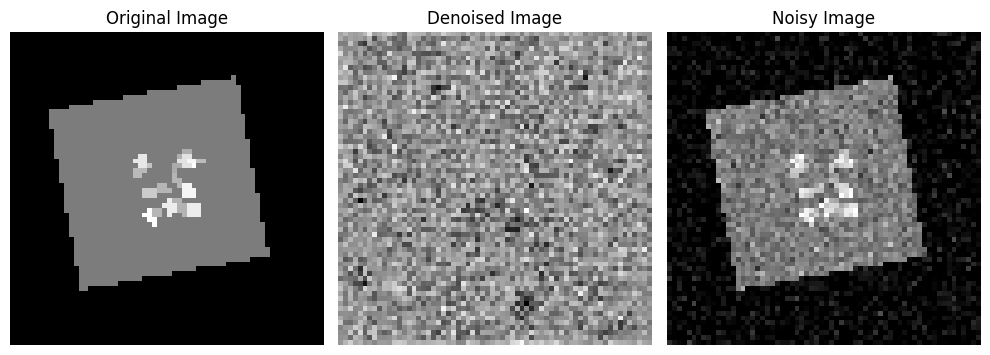

[2023-09-03 17:52:05] Intermediate result: {"iteration": 0, "loss": 0.14298, "psnr_noisy": 8.4473}  (Index 62)
[2023-09-03 17:52:25] Intermediate result: {"iteration": 10, "loss": 0.04561, "psnr_noisy": 13.40899}  (Index 63)
[2023-09-03 17:52:44] Intermediate result: {"iteration": 20, "loss": 0.0485, "psnr_noisy": 13.14295}  (Index 64)
[2023-09-03 17:53:03] Intermediate result: {"iteration": 30, "loss": 0.01832, "psnr_noisy": 17.37112}  (Index 65)
[2023-09-03 17:53:22] Intermediate result: {"iteration": 40, "loss": 0.08009, "psnr_noisy": 10.96444}  (Index 66)
[2023-09-03 17:53:42] Intermediate result: {"iteration": 50, "loss": 0.02575, "psnr_noisy": 15.89305}  (Index 67)


In [4]:

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=64, pretrained=False)

num_iter=1
total_iterations = 2000
phantom = np.load(f'phantoms/ground_truth/64/{0}.npy')
phantom_noisy = add_gaussian_noise(torch.from_numpy(phantom)[None, :], noise_factor=.09).squeeze(1).numpy()

# Create the lightning module
module = LightningEvalSearchSGLD(
                phantom=phantom, 
                phantom_noisy=phantom_noisy,
                num_iter=num_iter,
                lr=0.14, # note a smaller learning rate affecs the SGLD, so overfitting happens FASTER at LOWER learning rates (start with 0.01)
                burnin_iter=1000,
                model_cls=model,
                show_every=300
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            max_epochs=total_iterations,
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=None)
lightning.fit(model)